In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc, make_scorer, precision_recall_curve, plot_precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import tree, metrics

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("Loan_Default.csv")

In [3]:
df.shape

(148670, 34)

In [4]:
df.head(10)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
5,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0
6,24896,2019,cf,Joint,pre,type1,p3,l1,nopc,nob/c,...,EXP,860,EXP,55-64,to_inst,79.109589,North,direct,0,44.0
7,24897,2019,NaN,Female,nopre,type1,p4,l1,nopc,nob/c,...,CIB,863,CIB,55-64,to_inst,86.525974,North,direct,0,42.0
8,24898,2019,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,...,CIB,580,EXP,55-64,to_inst,78.765690,central,direct,0,44.0
9,24899,2019,cf,Sex Not Available,nopre,type3,p3,l1,nopc,nob/c,...,CIB,788,EXP,55-64,to_inst,63.444767,south,direct,0,30.0


In [5]:
# Checking for dtype and nulls 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [6]:
# Drop ID, year. These columns are not useful. 
df.drop(columns= ['ID','year'], inplace=True)

# Dropped rate_of_interest, Upfront_charges, Interest_rate_spread, property_value, LTV as they are a direct indicator of Status. Heavily imbalanced. 
df.drop(columns= ['rate_of_interest','Upfront_charges','Interest_rate_spread','property_value','LTV'], inplace=True) 

In [7]:
# List the numeric columns
num = [col for col in df.columns if df[col].dtype != 'object']
print(num)

['loan_amount', 'term', 'income', 'Credit_Score', 'Status', 'dtir1']


In [8]:
# List the categorical columns
obj = [col for col in df.columns if df[col].dtype == 'object']
print(obj)

['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount,148670.0,331117.743997,183909.310127,16500.0,196500.0,296500.0,436500.0,3576500.0
term,148629.0,335.136582,58.409084,96.0,360.0,360.0,360.0,360.0
income,139520.0,6957.338876,6496.586382,0.0,3720.0,5760.0,8520.0,578580.0
Credit_Score,148670.0,699.789103,115.875857,500.0,599.0,699.0,800.0,900.0
Status,148670.0,0.246445,0.430942,0.0,0.0,0.0,0.0,1.0
dtir1,124549.0,37.732932,10.545435,5.0,31.0,39.0,45.0,61.0


In [10]:
df.describe(include="object").T

,count,unique,top,freq
loan_limit,145326,2,cf,135348
Gender,148670,4,Male,42346
approv_in_adv,147762,2,nopre,124621
loan_type,148670,3,type1,113173
loan_purpose,148536,4,p3,55934
Credit_Worthiness,148670,2,l1,142344
open_credit,148670,2,nopc,148114
business_or_commercial,148670,2,nob/c,127908
Neg_ammortization,148549,2,not_neg,133420
interest_only,148670,2,not_int,141560


In [11]:
# List the unique values in each numeric column 
pd.Series({col: df[col].unique() for col in df[num].columns})

loan_amount     [116500, 206500, 406500, 456500, 696500, 70650...
term            [360.0, 300.0, 180.0, 312.0, 144.0, 240.0, 348...
income          [1740.0, 4980.0, 9480.0, 11880.0, 10440.0, 100...
Credit_Score    [758, 552, 834, 587, 602, 864, 860, 863, 580, ...
Status                                                     [1, 0]
dtir1           [45.0, nan, 46.0, 42.0, 39.0, 40.0, 44.0, 30.0...
dtype: object

In [12]:
# List the unique values in each categorical column
pd.Series({col: df[col].unique() for col in df[obj].columns})

loan_limit                                                      [cf, nan, ncf]
Gender                                [Sex Not Available, Male, Joint, Female]
approv_in_adv                                                [nopre, pre, nan]
loan_type                                                [type1, type2, type3]
loan_purpose                                             [p1, p4, p3, p2, nan]
Credit_Worthiness                                                     [l1, l2]
open_credit                                                        [nopc, opc]
business_or_commercial                                            [nob/c, b/c]
Neg_ammortization                                      [not_neg, neg_amm, nan]
interest_only                                              [not_int, int_only]
lump_sum_payment                                              [not_lpsm, lpsm]
construction_type                                                     [sb, mh]
occupancy_type                                      

In [13]:
df.isna().sum()

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
Region                           0
Security_Type                    0
Status                           0
dtir1                        24121
dtype: int64

In [14]:
null_perc = df.isna().sum()/df.shape[0]
null_perc

loan_limit                   0.022493
Gender                       0.000000
approv_in_adv                0.006107
loan_type                    0.000000
loan_purpose                 0.000901
Credit_Worthiness            0.000000
open_credit                  0.000000
business_or_commercial       0.000000
loan_amount                  0.000000
term                         0.000276
Neg_ammortization            0.000814
interest_only                0.000000
lump_sum_payment             0.000000
construction_type            0.000000
occupancy_type               0.000000
Secured_by                   0.000000
total_units                  0.000000
income                       0.061546
credit_type                  0.000000
Credit_Score                 0.000000
co-applicant_credit_type     0.000000
age                          0.001345
submission_of_application    0.001345
Region                       0.000000
Security_Type                0.000000
Status                       0.000000
dtir1       

In [15]:
# before imputation, drop columns with > 20% null 
null_perc[null_perc > 0.2].index

Index([], dtype='object')

In [16]:
drop_cols = list(null_perc[null_perc > 0.2].index)
df = df.drop(drop_cols, axis = 1)

In [17]:
df.shape

(148670, 27)

In [18]:
# remove rows with 4 or more missing columns 
for idx in range(df.shape[0]):
    df.loc[idx, 'missing_cnt'] = df.iloc[idx, :].isnull().sum()

In [19]:
threshold = 4
df.drop(df[df['missing_cnt'] >= threshold].index, axis = 0, inplace = True)

df.shape

(148355, 28)

In [20]:
# Rename values in age as XGB cannot process > and < symbols 
df.loc[df['age'] == '<25', 'age'] = 'less_than_25'
df.loc[df['age'] == '>74', 'age'] = 'more_than_74'

In [21]:
df.drop(columns= ['missing_cnt'], inplace=True)

In [22]:
df1 = df.copy()

In [23]:
# Use fillna to impute null values with median in numeric columns 
df1.fillna(df1[num].median(), inplace = True)

In [24]:
# Use fillna to impute null values with mode in categorical columns 
l = df1[obj].mode()
df1[obj] = df1[obj].fillna(value=l.iloc[0])

In [25]:
df1.isna().sum()

loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
Status                       0
dtir1                        0
dtype: int64

In [26]:
# Plot correlation matrix for visual of multicollinearity
corrMatrix = df1.corr()
corrMatrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

,loan_amount,term,income,Credit_Score,Status,dtir1
loan_amount,1.000,0.174,0.441,0.004,-0.035,0.015
term,0.174,1.000,-0.057,-0.003,0.000,0.106
income,0.441,-0.057,1.000,0.001,-0.060,-0.255
Credit_Score,0.004,-0.003,0.001,1.000,0.004,-0.000
Status,-0.035,0.000,-0.060,0.004,1.000,0.082
dtir1,0.015,0.106,-0.255,-0.000,0.082,1.000


In [27]:
# All features 
df1_num = list(df1.select_dtypes(include = np.number).columns)
df1_obj = list(df1.select_dtypes(include = np.object).columns) 

In [28]:
df1_num

['loan_amount', 'term', 'income', 'Credit_Score', 'Status', 'dtir1']

In [29]:
df1_obj

['loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_type',
 'loan_purpose',
 'Credit_Worthiness',
 'open_credit',
 'business_or_commercial',
 'Neg_ammortization',
 'interest_only',
 'lump_sum_payment',
 'construction_type',
 'occupancy_type',
 'Secured_by',
 'total_units',
 'credit_type',
 'co-applicant_credit_type',
 'age',
 'submission_of_application',
 'Region',
 'Security_Type']

In [30]:
dum = pd.get_dummies(df1[df1_obj], drop_first=True)

In [31]:
df1_mod = pd.concat([df1[df1_num], dum], axis = 1)

In [32]:
df1_mod.shape

(148355, 44)

In [33]:
df1_mod.head()

,loan_amount,term,income,Credit_Score,Status,dtir1,loan_limit_ncf,Gender_Joint,Gender_Male,Gender_Sex Not Available,...,age_45-54,age_55-64,age_65-74,age_less_than_25,age_more_than_74,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
0,116500,360.0,1740.0,758,1,45.0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
1,206500,360.0,4980.0,552,1,39.0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,406500,360.0,9480.0,834,0,46.0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,456500,360.0,11880.0,587,0,42.0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,696500,360.0,10440.0,602,0,39.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
x = df1_mod.drop('Status', axis = 1)
y = df1_mod['Status']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.3, random_state = 10)

In [36]:
print(f'{round(sum(y==1)/y.count()*100,3)} % is positive for target variable')

24.555 % is positive for target variable


In [37]:
x_train.head()

,loan_amount,term,income,Credit_Score,dtir1,loan_limit_ncf,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_pre,...,age_45-54,age_55-64,age_65-74,age_less_than_25,age_more_than_74,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
17483,306500,180.0,9300.0,611,39.0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,1
91402,256500,360.0,9060.0,776,44.0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
129964,596500,360.0,7320.0,797,42.0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
96927,446500,360.0,4800.0,566,49.0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,1
59689,776500,360.0,42000.0,690,19.0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [38]:
dum_m = DummyClassifier()
lr_m = LogisticRegression(random_state = 100)
dt_m = DecisionTreeClassifier(random_state = 100)
rf_m = RandomForestClassifier(random_state = 100)
xgb_m = XGBClassifier(random_state=100)

In [39]:
def model(mods, x_train, y_train, x_test, y_test):
    for mod in mods:
        mod.fit(x_train, y_train)
        
        predict_train = mod.predict(x_train)
        accuracy_train = accuracy_score(y_train,predict_train)
        precision_train = precision_score(y_train,predict_train)
        recall_train = recall_score(y_train,predict_train)
        f1_train = f1_score(y_train, predict_train)
        print(mod)
        print('train accuracy: ', round(accuracy_train,3))
        print('train precision: ', round(precision_train,3))
        print('train recall: ', round(recall_train,3))
        print('train f1: ', round(f1_train,3))
        print('confusion matrix (train)')
        print(confusion_matrix(y_train, predict_train))
        print('\n')
        
        predict_test = mod.predict(x_test)
        accuracy_test = accuracy_score(y_test, predict_test)
        precision_test = precision_score(y_test, predict_test)
        recall_test = recall_score(y_test, predict_test)
        f1_test = f1_score(y_test, predict_test)
        print('test accuracy: ', round(accuracy_test,3))
        print('test precision: ', round(precision_test,3))
        print('test recall: ', round(recall_test,3))
        print('test f1: ', round(f1_test,3))
        print('confusion matrix (test)')
        print(confusion_matrix(y_test, predict_test))
        print('\n')
        
        print(metrics.classification_report(y_test, predict_test))

In [40]:
# train models on train set
mods = [dum_m, lr_m, dt_m, rf_m, xgb_m]
model(mods, x_train, y_train, x_test, y_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


DummyClassifier()
train accuracy:  0.632
train precision:  0.249
train recall:  0.248
train f1:  0.249
confusion matrix (train)
[[59258 19091]
 [19164  6335]]


test accuracy:  0.633
test precision:  0.251
test recall:  0.249
test f1:  0.25
confusion matrix (test)
[[25434  8144]
 [ 8206  2723]]


              precision    recall  f1-score   support

           0       0.76      0.76      0.76     33578
           1       0.25      0.25      0.25     10929

    accuracy                           0.63     44507
   macro avg       0.50      0.50      0.50     44507
weighted avg       0.63      0.63      0.63     44507



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(random_state=100)
train accuracy:  0.754
train precision:  0.0
train recall:  0.0
train f1:  0.0
confusion matrix (train)
[[78349     0]
 [25499     0]]


test accuracy:  0.754
test precision:  0.0
test recall:  0.0
test f1:  0.0
confusion matrix (test)
[[33578     0]
 [10929     0]]




C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86     33578
           1       0.00      0.00      0.00     10929

    accuracy                           0.75     44507
   macro avg       0.38      0.50      0.43     44507
weighted avg       0.57      0.75      0.65     44507

DecisionTreeClassifier(random_state=100)
train accuracy:  1.0
train precision:  1.0
train recall:  1.0
train f1:  1.0
confusion matrix (train)
[[78349     0]
 [    1 25498]]


test accuracy:  0.805
test precision:  0.598
test recall:  0.632
test f1:  0.614
confusion matrix (test)
[[28942  4636]
 [ 4026  6903]]


              precision    recall  f1-score   support

           0       0.88      0.86      0.87     33578
           1       0.60      0.63      0.61     10929

    accuracy                           0.81     44507
   macro avg       0.74      0.75      0.74     44507
weighted avg       0.81      0.81      0.81     44507

RandomForestClassifier(random_st

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
train accuracy:  0.896
train precision:  0.946
train recall:  0.612
train f1:  0.743
confusion matrix (tra

In [41]:
# probability
dum_p = dum_m.predict_proba(x_test)
lr_p = lr_m.predict_proba(x_test)
dt_p = dt_m.predict_proba(x_test)
rf_p = rf_m.predict_proba(x_test)
xgb_p = xgb_m.predict_proba(x_test)

In [42]:
dum_p = dum_p[:, 1]
lr_p = lr_p[:, 1]
dt_p = dt_p[:, 1]
rf_p = rf_p[:, 1]
xgb_p = xgb_p[:, 1]

In [43]:
# auc
dum_a = roc_auc_score(y_test, dum_p)
lr_a = roc_auc_score(y_test, lr_p)
dt_a = roc_auc_score(y_test, dt_p)
rf_a = roc_auc_score(y_test, rf_p)
xgb_a = roc_auc_score(y_test, xgb_p)

In [44]:
print('auc')
auc = {'dum':dum_a, 'lr':lr_a, 'dt':dt_a, 'rf':rf_a, 'xgb':xgb_a}
for a in auc:
    print(a, round(auc[a],3))

auc
dum 0.499
lr 0.56
dt 0.747
rf 0.861
xgb 0.875


In [45]:
# an AUC of 0.7 to 0.8 is considered acceptable 
# 0.8 to 0.9 is considered excellent 
# > 0.9 is considered outstanding 

fpr_dum, tpr_dum, threshold_dum = roc_curve(y_test, dum_p)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, lr_p)
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test, dt_p)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, rf_p)
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test, xgb_p)

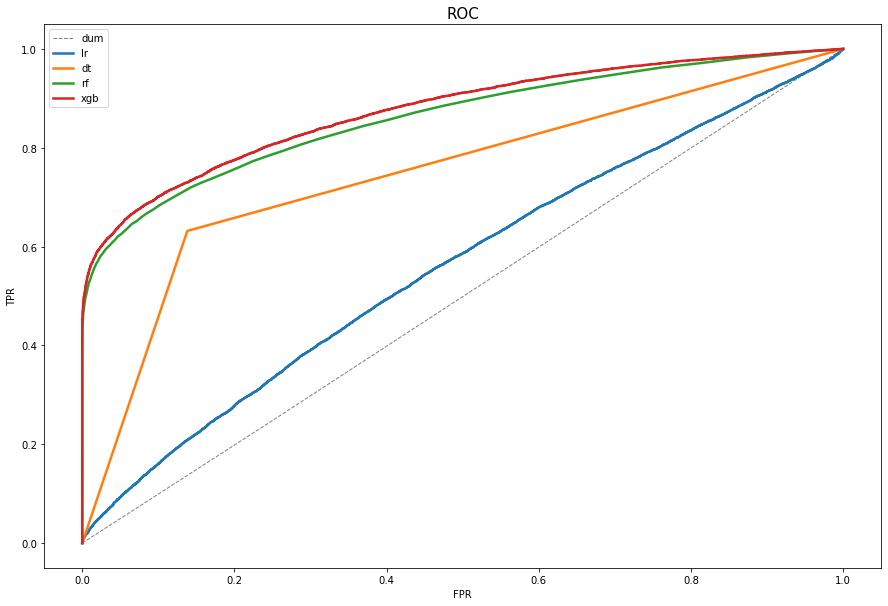

In [46]:
# roc curve 
plt.figure(figsize = (15,10))
plt.plot(fpr_dum, tpr_dum, color='grey', linewidth = 1, linestyle = '--', label = 'dum')
plt.plot(fpr_lr, tpr_lr, linewidth = 2.5, label = 'lr')
plt.plot(fpr_dt, tpr_dt, linewidth = 2.5, label = 'dt')
plt.plot(fpr_rf, tpr_rf, linewidth = 2.5, label = 'rf')
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2.5, label = 'xgb')

plt.title('ROC', fontsize = 15)
plt.xlabel('FPR', fontsize = 10)
plt.ylabel('TPR', fontsize = 10)
plt.legend(fontsize = 10)
plt.show()